In [1]:
import datetime
from dateutil.relativedelta import relativedelta
import itertools
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Initialize the input

In [2]:
my_bd = datetime.datetime(1994,7,28,0,0,0)
current_date = datetime.datetime.now()

In [3]:
n_years_on_chart = 90
N_WEEKS_PER_YEAR = 53

# Areas to fill

In [4]:
areas_to_fill = [
    {
        'start_date': datetime.datetime(2016,9,1), 
        'end_date': current_date, 
        'name': "phd", 
        'color': (0, 0, 0)
    },
    {
        'start_date': my_bd, 
        'end_date': datetime.datetime(1995,7,28), 
        'name': "learning to walk",
        'color': (255, 0, 0)
    },
    {
        'start_date': datetime.datetime(1995,7,29), 
        'end_date': datetime.datetime(2000,8,31), 
        'name': "happy days", 
        'color': (0, 0, 255)
    },
    {
        'start_date': datetime.datetime(2016,7,1), 
        'end_date': datetime.datetime(2016,8,31), 
        'name': "working again", 
        'color': (255, 255, 0)
    },
    {
        'start_date': datetime.datetime(2000,9,1), 
        'end_date': datetime.datetime(2012,5,31), 
        'name': "school", 
        'color': (0, 255, 0)
    },
    {
        'start_date': datetime.datetime(2012,6,1), 
        'end_date': datetime.datetime(2012,8,31), 
        'name': "working", 
        'color': (128, 0, 255)
    },
    {
        'start_date': datetime.datetime(2012,9,1), 
        'end_date': datetime.datetime(2016,6,30), 
        'name': "undergrad", 
        'color': (0, 255, 255)
    },
]

sorting the areas by start date, so that in case of an overlap the later area will overwrite the earlier one

In [5]:
areas_to_fill = sorted(areas_to_fill, key=lambda a: a['start_date']) 

# Create the life calendar

## create a unit square

In [6]:
unit_square_size = 20
unit_square_line_offset = 2
unit_square = np.ones((unit_square_size, unit_square_size, 3), dtype=np.uint8) * 255
unit_square[unit_square_line_offset, unit_square_line_offset:unit_square_size - unit_square_line_offset, :] = 0
unit_square[unit_square_size - unit_square_line_offset - 1, unit_square_line_offset:unit_square_size - unit_square_line_offset, :] = 0
unit_square[unit_square_line_offset:unit_square_size - unit_square_line_offset, unit_square_line_offset, :] = 0
unit_square[unit_square_line_offset:unit_square_size - unit_square_line_offset, unit_square_size - unit_square_line_offset - 1, :] = 0

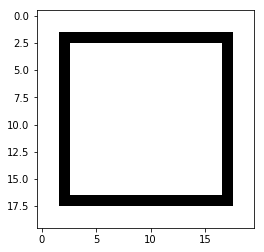

In [7]:
plt.imshow(unit_square)

In [8]:
full_unit = np.zeros((unit_square_size, unit_square_size, 3), dtype=np.uint8)
full_unit[:, :unit_square_line_offset, :] = 255
full_unit[:, -unit_square_line_offset:, :] = 255
full_unit[:unit_square_line_offset, :, :] = 255
full_unit[-unit_square_line_offset:, :, :] = 255

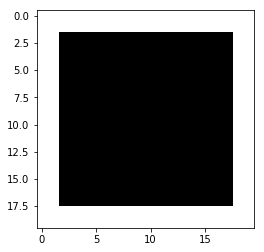

In [9]:
plt.imshow(full_unit)

In [10]:
today_unit = np.ones((unit_square_size, unit_square_size, 3), dtype=np.uint8) * 255
today_unit[int(unit_square_size / 3):-int(unit_square_size / 3), int(unit_square_size / 3):-int(unit_square_size / 3), :] = [255, 0, 0]

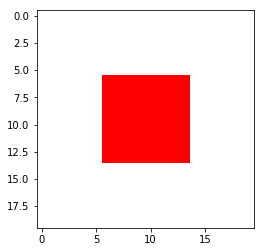

In [11]:
plt.imshow(today_unit)

## create the grid

In [12]:
empty_life_grid = np.tile(unit_square, (n_years_on_chart, N_WEEKS_PER_YEAR, 1))

In [13]:
def date2year_week_coords(date, bd):
    year = relativedelta(date, bd).years + 1
    week = int(np.floor((date - (bd + relativedelta(years=year-1))).days / 7) + 1)
    # np.ceil is not what we want
    return year, week

In [14]:
def get_year_week_pairs(bd, start_date, end_date):
    start_year, start_week = date2year_week_coords(start_date, bd)
    end_year, end_week = date2year_week_coords(end_date, bd)
    
    list_of_year_week_tuples = []
    if end_year == start_year:
        list_of_year_week_tuples.extend([(end_year, w) for w in range(start_week, end_week + 1)])
    else:
        list_of_year_week_tuples.extend([(start_year, w) for w in range(start_week, N_WEEKS_PER_YEAR + 1)])
        list_of_year_week_tuples.extend([(end_year, w) for w in range(1, end_week + 1)])
        if end_year - start_year > 1:
            list_of_year_week_tuples.extend(list(itertools.product(range(start_year+1, end_year), range(1, N_WEEKS_PER_YEAR + 1))))
    return list_of_year_week_tuples

color the grid

In [15]:
life_grid = empty_life_grid.copy()
patch_list = []
for area in areas_to_fill:
    list_of_year_week_tuples = get_year_week_pairs(
        bd=my_bd, start_date=area['start_date'], end_date=area['end_date']
    )
    colored_unit = full_unit.copy()
    colored_unit[colored_unit[:,:,0] == 0] = area['color']
    for (year, week) in list_of_year_week_tuples:
        life_grid[
            (year - 1)  * unit_square_size : year * unit_square_size,
            (week - 1) * unit_square_size : week * unit_square_size,
            :
        ] = colored_unit
        
    # create the color legend for the plot
    patch_list.append(mpatches.Patch(color=tuple(rgb / 255 for rgb in area['color']), label=area['name']))

add a special marker for the current week

In [16]:
today_year, today_week = get_year_week_pairs(
    bd=my_bd, start_date=area['end_date'], end_date=area['end_date']
)[0]
life_grid[
    (today_year - 1)  * unit_square_size : today_year * unit_square_size,
    (today_week - 1) * unit_square_size : today_week * unit_square_size,
    :
] = today_unit

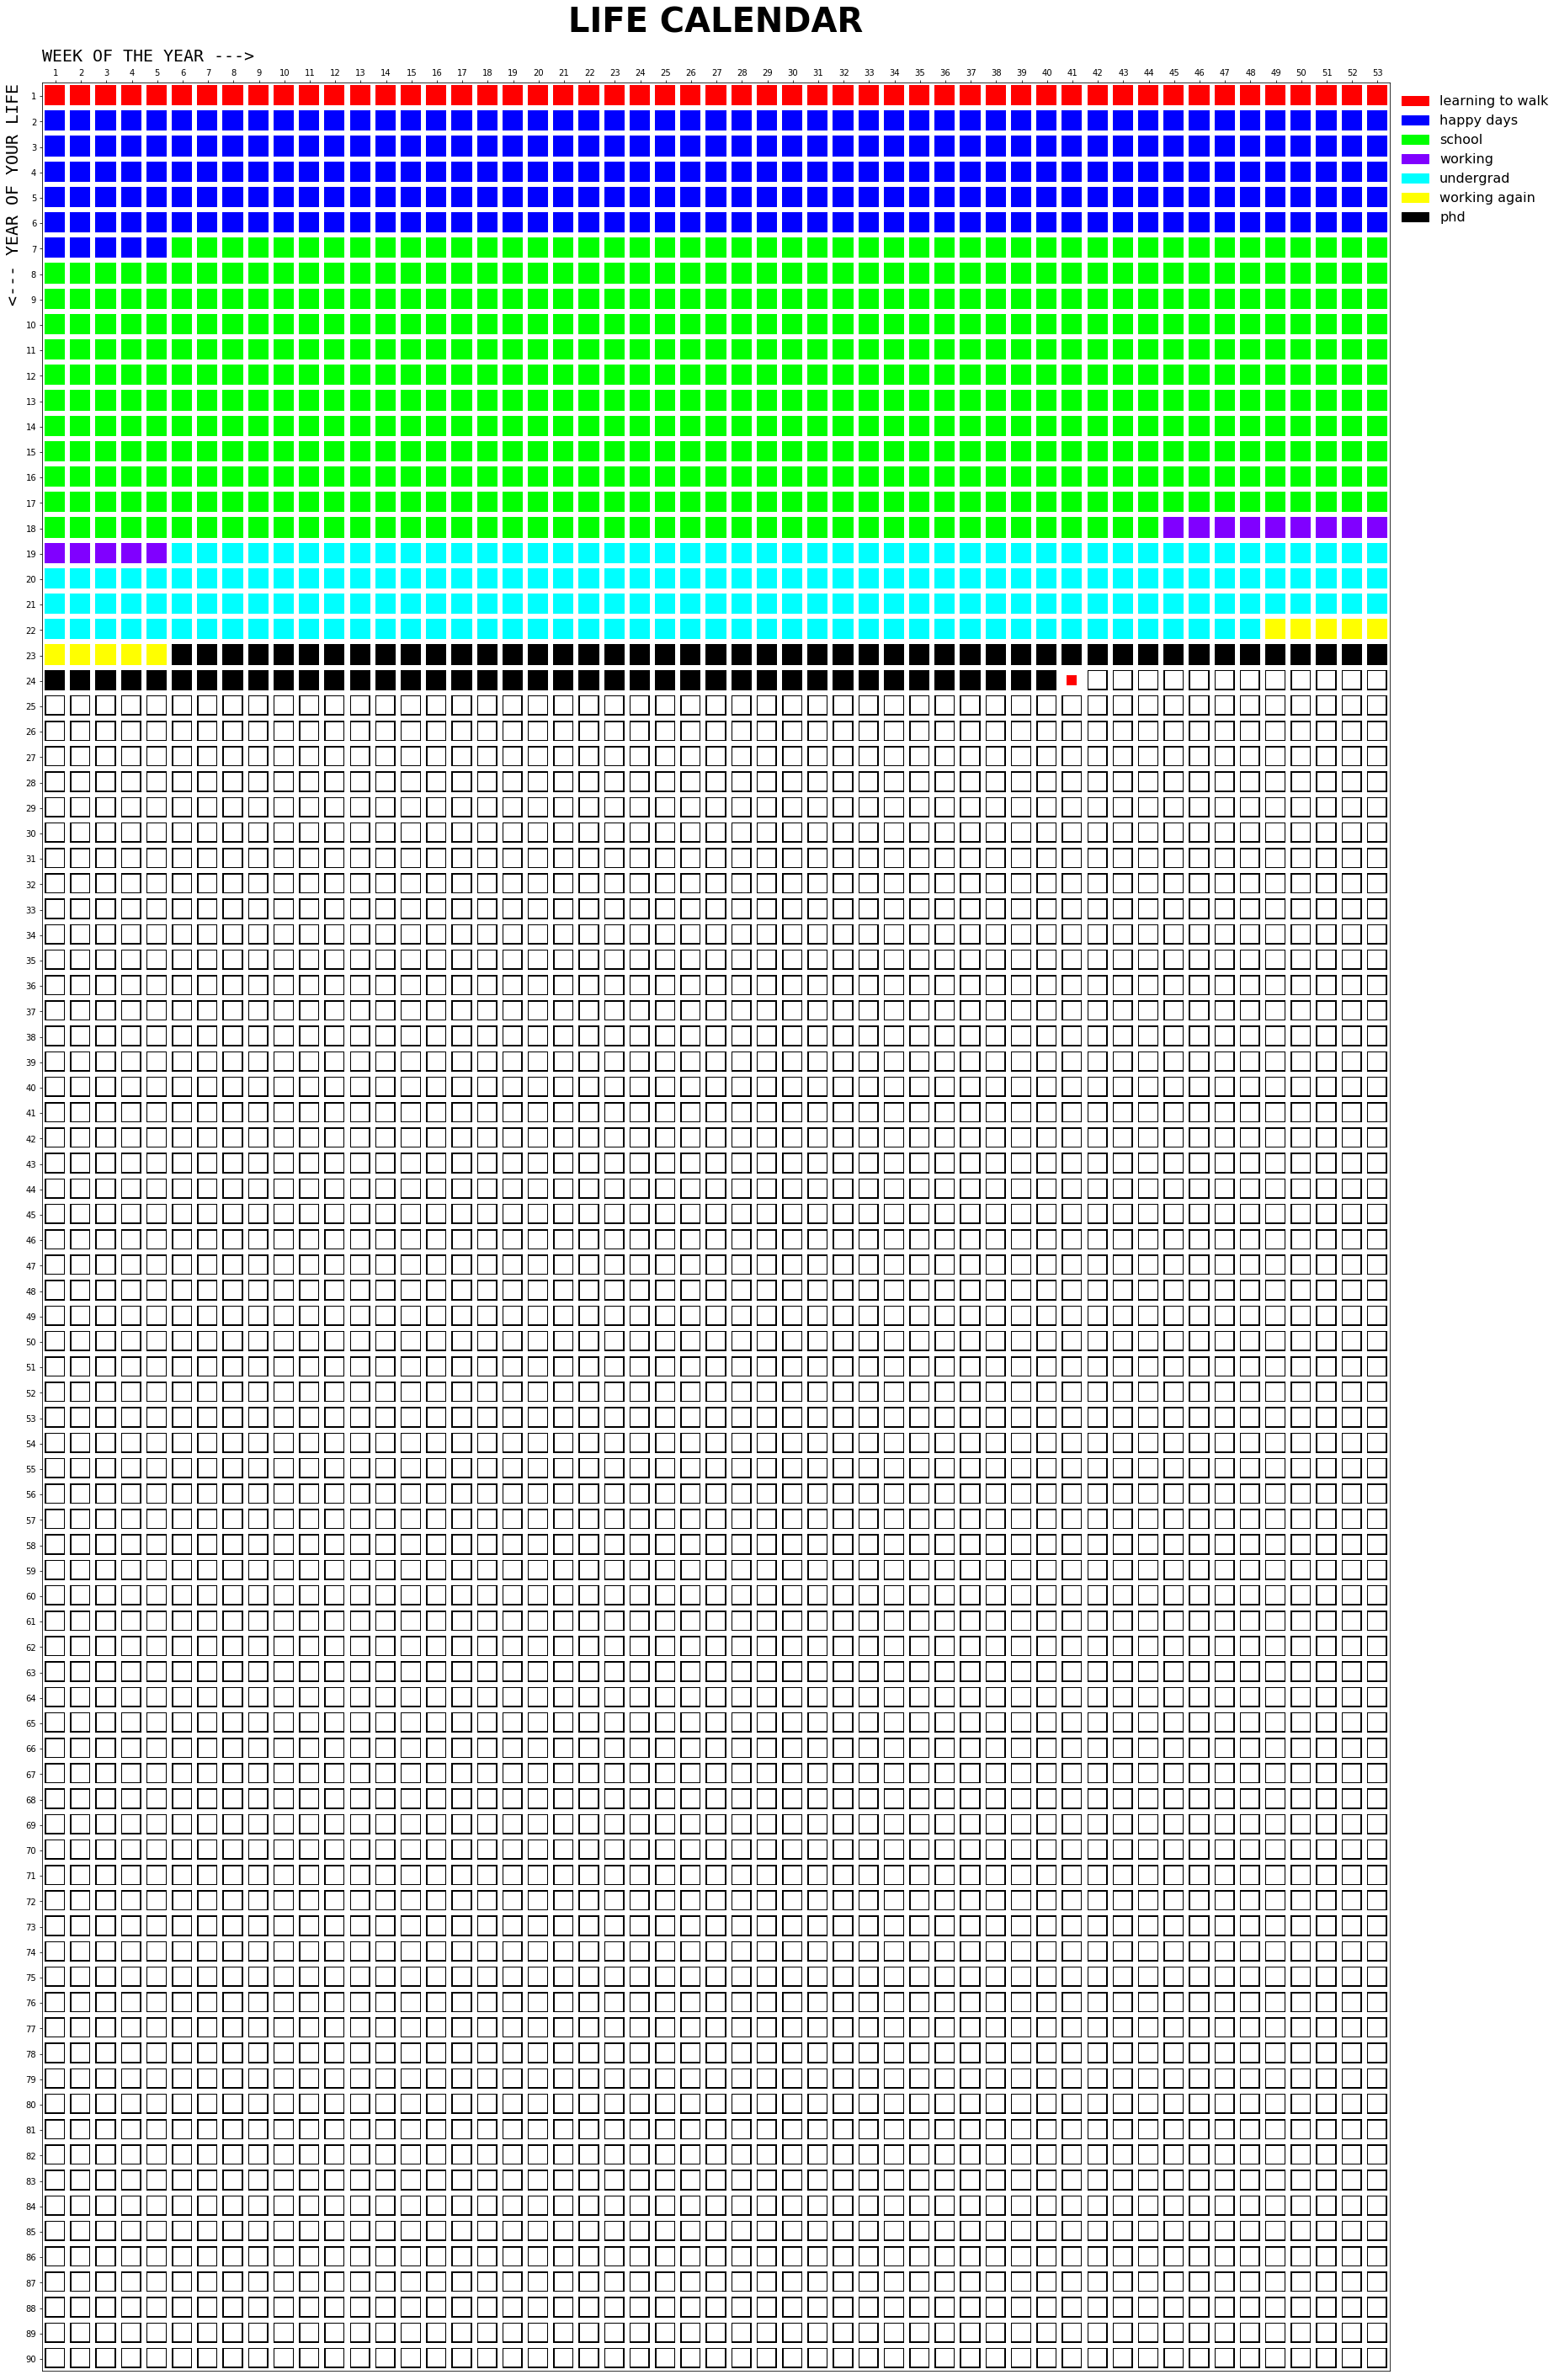

In [17]:
life_grid_fig = plt.figure(figsize=(40, 50))
ax = life_grid_fig.add_subplot(1, 1, 1)
ax.imshow(life_grid)
plt.xticks(
    range(int(unit_square_size/2), unit_square_size * N_WEEKS_PER_YEAR, unit_square_size), 
    (str(week) for week in range(1, N_WEEKS_PER_YEAR + 1))
)
plt.yticks(
    range(int(unit_square_size/2), unit_square_size * n_years_on_chart, unit_square_size),
    (str(year) for year in range(1, n_years_on_chart + 1))
)
ax.xaxis.tick_top()
ax.set_xlabel('WEEK OF THE YEAR --->', fontdict={'fontsize': 20, 'horizontalalignment': "left"}, family="monospace")
ax.set_ylabel('<--- YEAR OF YOUR LIFE', fontdict={'fontsize': 20, 'horizontalalignment': "right"}, family="monospace")
ax.xaxis.set_label_coords(0.00, 1.015)
ax.yaxis.set_label_coords(-0.015, 1.0)
plt.title("LIFE CALENDAR", fontdict={'fontsize': 40}, loc="center", weight="demibold", position=(0.50, 1.02))

# add legend
plt.legend(handles=patch_list, bbox_to_anchor=(1, 1), loc="upper left", fontsize=16, frameon=False);

In [18]:
life_grid_fig.savefig("sample_life_calendar.png", format="PNG", bbox_inches="tight")